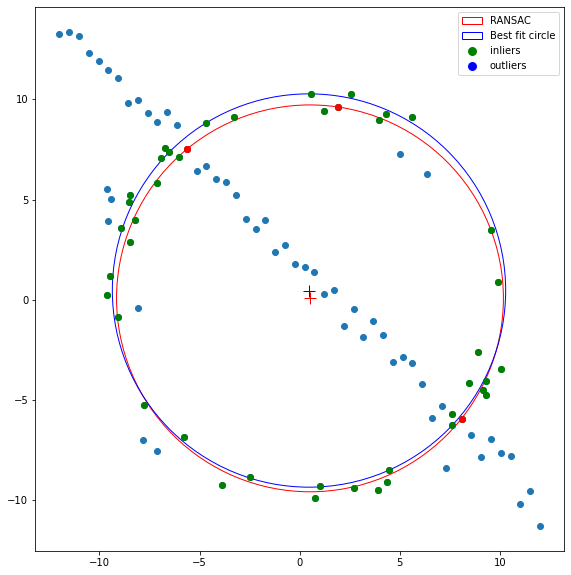

In [170]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt 
from math import sqrt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def noisy_data():
    N = 100
    half_n = N // 2
    r = 10
    s = r/16
    t = np.random.uniform(0 , 2*np.pi , half_n )
    n = s*np.random.randn(half_n)
    x , y = (r+n)*np.cos(t),(r + n)*np.sin(t)
    X_circ = np.hstack((x.reshape(half_n , 1 ) , y.reshape( half_n , 1 ) ) )
    m, b = -1, 2
    x = np.linspace(-12, 12 , half_n )
    y = m*x + b + s*np.random.randn( half_n )
    X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )
    X = np.vstack(( X_circ , X_line ) )

    

    return X


def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return (None, np.inf)

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)


def ransac(data_set, threshold_dist, threshold_inliner_count, max_iteraions):
    iter = max_iteraions
    shortlisted = []
    #Runing the algorithm for defined max_iterations
    while max_iteraions:
        size_of_data = len(data_set)
        init_indices = np.random.randint(size_of_data, size = (3))
        init_cordinates = [data_set[i] for i in init_indices]

        #finding the circle passing through the init_cordinates
        centre1, radius1 = define_circle(init_cordinates[0], init_cordinates[1], init_cordinates[2])

        if centre1 is not None and radius1 < 15:
            count = 0
            new_inliers = []
            for i in data_set:
                dist = sqrt((i[0] - centre1[0])**2 + (i[1] - centre1[1])**2)
                if dist > (radius1 - threshold_dist) and dist < (radius1 + threshold_dist):
                    count += 1
                    new_inliers.append(i)
            inliers = np.array(new_inliers)

            #If number of inliers are greater than threshold count
            if count > threshold_inliner_count:
                iter2 = iter
                while iter2:
                    new_data_set = inliers
                    size_of_data = len(new_data_set)
                    init_indices = np.random.randint(size_of_data, size = (3))
                    init_cordinates = [new_data_set[i] for i in init_indices]

                    #finding the circle passing through the init_cordinates for new data set
                    centre2, radius2 = define_circle(init_cordinates[0], init_cordinates[1], init_cordinates[2])
                    
                    if centre2 is not None:
                        count = 0
                        new_inliers = []
                        for i in new_data_set:
                            dist = sqrt((i[0] - centre2[0])**2 + (i[1] - centre2[1])**2)
                            if dist > (radius2 - threshold_dist) and dist < (radius2 + threshold_dist):
                                count += 1
                                new_inliers.append(i)
                        inliers = np.array(new_inliers)

                        if count > threshold_inliner_count:

                            #calculate mean absolute error
                            mse = np.array([sqrt(i[0] + i[1]) for i in (inliers - centre2)**2]) - radius2
                            mse = sum([abs(i) for i in mse]) / len(inliers)
                    
                            shortlisted.append((centre2,radius2,len(inliers),mse , init_cordinates, new_inliers, centre1, radius1))
                    
                    iter2 -= 1
            
        max_iteraions -= 1

    max_inliers = threshold_inliner_count
    best_option = 0
    min_error = 1000
    for i in shortlisted:
        if i[2] > max_inliers:
            max_inliers = i[2]
            best_option = i
        
        elif i[2] == max_inliers:
            if i[3] < min_error:
                min_error = i[3]
                best_option = i
                
    return best_option


X1 = noisy_data()
X_data = []
Y_data = []
for vals in X1:
    X_data.append(vals[0])
    Y_data.append(vals[1])


fig, ax = plt.subplots(figsize= (10,10))
ax.scatter(X_data, Y_data)


# show result
result = ransac(X1, 1, 30, 100) 
(a,b),r = result[0],result[1]
initial_cord = result[4]
inliers = result[5]
best_fit_centre = result[6]
best_fit_radius = result[7]

circle = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False, label = 'RANSAC')
circle2 = plt.Circle(best_fit_centre, radius= best_fit_radius, color='b', fc='y', fill=False, label = 'Best fit circle')
plt.gca().add_patch(circle)
plt.gca().add_patch(circle2)



plt.plot(a, b, 'r', marker='+', markersize=12)
plt.plot(best_fit_centre[0], best_fit_centre[1], 'b', marker='+', markersize=12)


for i in inliers:
    plt.plot(i[0], i[1], 'g', marker='o')

for i in initial_cord:
    plt.plot(i[0], i[1], 'r', marker='o')





handles, labels = ax.get_legend_handles_labels()
legend =  [Line2D([0], [0], marker='o', color='w', label='inliers',
                          markerfacecolor='g', markersize=10), Line2D([0], [0], marker='o', color='w', label='outliers',
                          markerfacecolor='b', markersize=10)]
handles.append(legend[0])
handles.append(legend[1])


plt.legend(handles=handles)
plt.axis('scaled')
plt.show()




In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

N = 4
global n
n = 0
pts_src = np.empty((N, 2))
pts_dst = np.empty((N, 2))

def draw_circle(event, x, y, flags, param):
    global n
    p = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (0, 0, 255), -1)
        p[n] = (x, y)
        n += 1


def stich_image(src_img, dst_image , blend):
    N = 4
    global n
    n = 0
    pts_src = np.empty((N, 2))
    pts_dst = np.empty((N, 2))
    
    im_src = cv2.imread(src_img)
    size = im_src.shape
    
    # Create a vector of source points.
    pts_src = np.array(
                        [
                            [0,0],
                            [size[1] - 1, 0],
                            [size[1] - 1, size[0] -1],
                            [0, size[0] - 1 ]
                            ],dtype=float
                        )


    im_dst = cv2.imread(dst_image)

    im_dst_copy = im_dst.copy()
    param = [pts_dst, im_dst_copy]
    cv2.namedWindow("Select Points", cv2.WINDOW_AUTOSIZE)
    cv2.setMouseCallback('Select Points', draw_circle, param)

    while (1):
        cv2.imshow("Select Points", im_dst_copy)
        if n == N:
            cv2.destroyAllWindows()
            break
            
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

    h, status = cv2.findHomography(pts_src, pts_dst)
    im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

    if blend == True:
        im_out1 = cv2.addWeighted(im_dst,1,im_out,.6,0)
    else:
        cv2.fillConvexPoly(im_dst, pts_dst.astype(int), 0, 16)
        im_out1 = im_dst + im_out

    fig, ax = plt.subplots(1,4, figsize= (40,40))

    ax[0].imshow(cv2.cvtColor(im_src , cv2.COLOR_BGR2RGB))
    ax[0].set_title('Source Image')
    ax[1].imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Warped Image')
    ax[2].imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
    ax[2].set_title('Destination Image')
    ax[3].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
    ax[3].set_title('Final Outcome')

    ax[0].set_xticks([]), ax[0].set_yticks([])
    ax[1].set_xticks([]), ax[1].set_yticks([])
    ax[2].set_xticks([]), ax[2].set_yticks([])
    ax[3].set_xticks([]), ax[3].set_yticks([])
    
    plt.show()

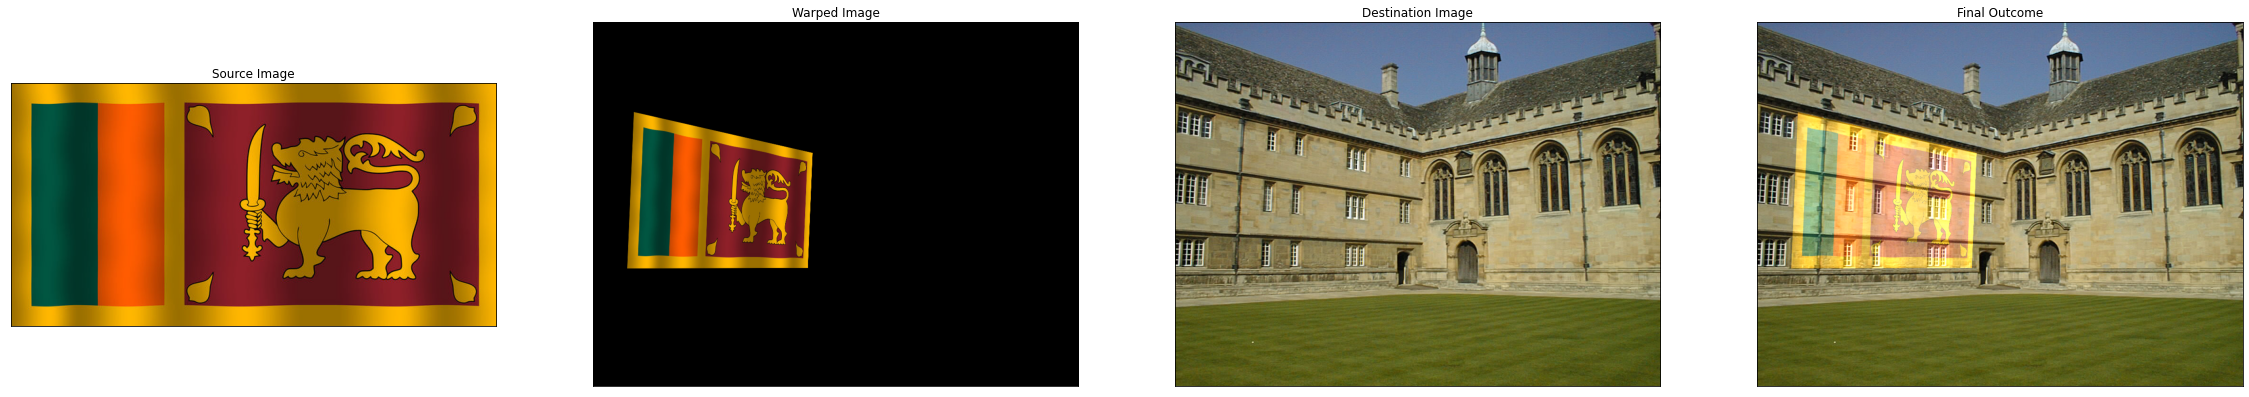

In [23]:
stich_image('flagsri.jpg', '001.jpg', True)

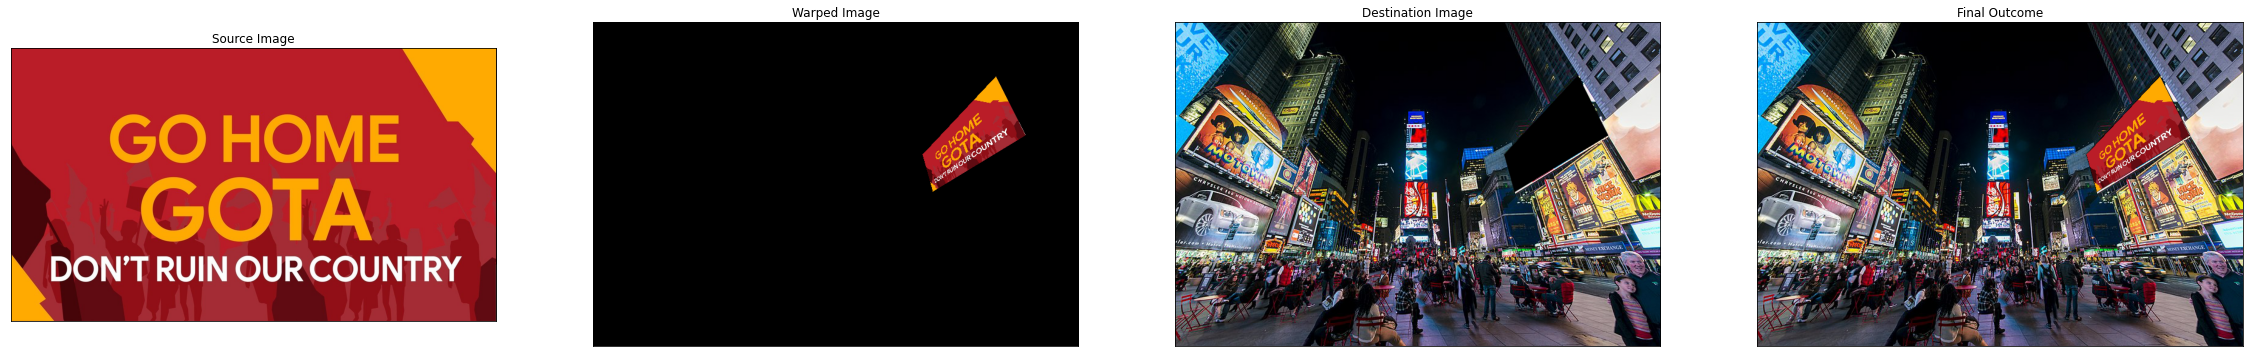

In [25]:
stich_image('gota.jpg', 'square.jpg', False)

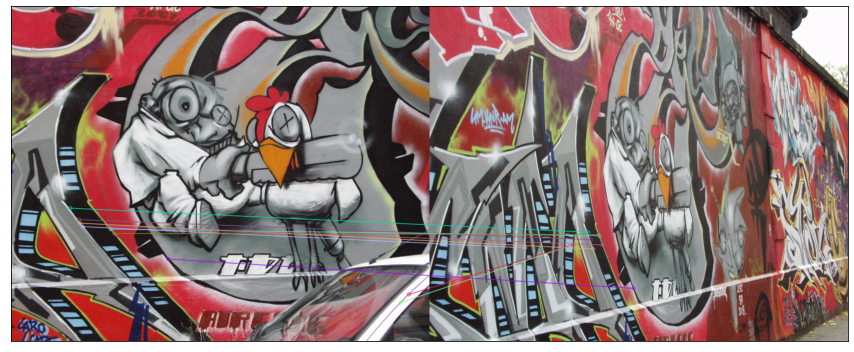

In [207]:
# Question 03
import cv2 
import matplotlib.pyplot as plt

img1 = cv2.imread('img1.ppm')  
img2 = cv2.imread('img5.ppm') 

sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma = 1)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#Making cross_check true is a good alternative to ratio test
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [366]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from math import sqrt
%matplotlib inline

def computeHomography(img1, img2):
    #reading image
    img1 = cv2.imread(img1)  
    img2 = cv2.imread(img2)  


    #keypoints
    sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma =1)
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)
    goodMatches = []
    for m, n in matches:
        if m.distance < 0.95 * n.distance:
            goodMatches.append(m)
    MIN_MATCH_COUNT = 10
    if len(goodMatches) > MIN_MATCH_COUNT:
        sourcePoints = np.float32([keypoints_1[m.queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
        destinationPoints = np.float32([keypoints_2[m.trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)


        max_iterations = 100
        threshold_inlier_count = 10
        shortlisted = []

        while max_iterations:
            size_of_data = len(sourcePoints)
            init_indices = np.random.randint(size_of_data, size = (4))
            init_cordinates = [sourcePoints[i][0] for i in init_indices]
            init_cordinate_matches = [destinationPoints[i][0] for i in init_indices]


            A = []
            for i in range(0, len(init_cordinates)):
                x, y = init_cordinates[i][0], init_cordinates[i][1]
                u, v = init_cordinate_matches[i][0], init_cordinate_matches[i][1]
                A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
                A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])

            A = np.asarray(A)
            U, S, Vh = np.linalg.svd(A)
            H = np.reshape(Vh[8], (3, 3))
            H = (1/H.item(8)) * H

            count = 0
            threshold_dist = 1
            inliers = []

            for i in range(len(sourcePoints)):
                p = np.array( [sourcePoints[i][0][0],sourcePoints[i][0][1],1]).reshape(3,1)

                Hp = np.matmul(H, p)
            
                estimatep2 = (1/Hp.item(2))*Hp

                p2 = np.transpose(np.matrix([destinationPoints[i][0][0], destinationPoints[i][0][1], 1]))
                error = p2 - estimatep2
                dist =  np.linalg.norm(error)
            
            
                if dist < threshold_dist:
                    count += 1
                    inliers.append(i)
            if count > threshold_inlier_count:
                size_of_data = len(inliers)
                init_indices = np.random.randint(size_of_data, size = (4))
                init_cordinates = [sourcePoints[i][0] for i in init_indices]
                init_cordinate_matches = [destinationPoints[i][0] for i in init_indices]

                A = []
                for i in range(0, len(init_cordinates)):
                    x, y = init_cordinates[i][0], init_cordinates[i][1]
                    u, v = init_cordinate_matches[i][0], init_cordinate_matches[i][1]
                    A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
                    A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
                A = np.asarray(A)
                U, S, Vh = np.linalg.svd(A)
                H = np.reshape(Vh[8], (3, 3))
                H = (1/H.item(8)) * H

                count = 0
                for i in range(len(sourcePoints)):
                    p = np.array(  [sourcePoints[i][0][0],sourcePoints[i][0][1],1]).reshape(3,1)

                    Hp = np.matmul(H, p)
                
                    estimatep2 = (1/Hp.item(2))*Hp

                    p2 = np.transpose(np.matrix([destinationPoints[i][0][0], destinationPoints[i][0][1], 1]))
                    error = p2 - estimatep2
                    dist =  np.linalg.norm(error)
            
            
                    if dist < threshold_dist:
                        count += 1
                        
                if count > threshold_inlier_count:
                    shortlisted.append((count, H))
        
            max_iterations-=1





    shortlisted = sorted(shortlisted,key =  lambda x:x[0])
    Homography = shortlisted[-1][1]
    
    return shortlisted[-1][1]


A = computeHomography('img1.ppm', 'img2.ppm')
B = computeHomography('img2.ppm', 'img3.ppm')
C = computeHomography('img3.ppm', 'img4.ppm')
D = computeHomography('img4.ppm', 'img5.ppm')

H = D @ C @ B @ A

print(H)


IndexError: list index out of range

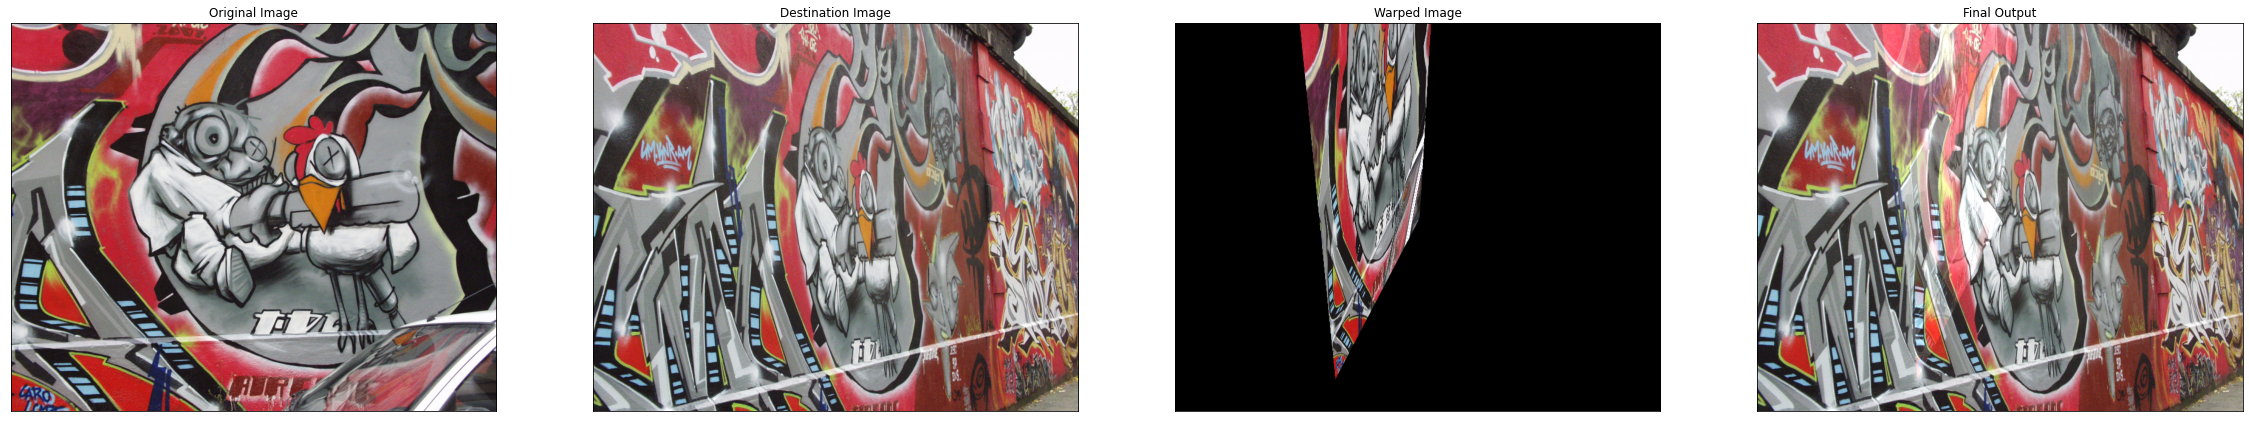

In [358]:
# H = np.array( [  6.2544644e-01 ,  5.7759174e-02  , 2.2201217e+02,
#    2.2240536e-01  , 1.1652147e+00 , -2.5605611e+01,
#    4.9212545e-04 , -3.6542424e-05  , 1.0000000e+00]).reshape(3,3)


img1 = cv2.imread('img1.ppm')  
img2 = cv2.imread('img5.ppm')

#1000,700
im4_warped = cv2.warpPerspective(img1, H , (img2.shape[1],img2.shape[0]))

im_out1 = cv2.addWeighted(img2,1,im4_warped,0.3,0)


fig, ax = plt.subplots(1,4,figsize= (40,20))
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(im4_warped, cv2.COLOR_BGR2RGB))
ax[3].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))

ax[0].set_title("Original Image")
ax[1].set_title("Destination Image")
ax[2].set_title("Warped Image")
ax[3].set_title("Final Output")

ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[2].set_xticks([]), ax[2].set_yticks([])
ax[3].set_xticks([]), ax[3].set_yticks([])
plt.show()




